In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('..')
from utils import load_results

In [2]:
collection = 'invariance_eval_forward_rotation_3d'


jk_config = {
    'username': 'schuchaj',
    'password': 'coolpassword',
    'host': 'hostofyourdatabase',
    'port': 27017,
    'db_name': 'nameofyourdatabase'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [3]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions, {'config':1, 'result': 1})
    
    return exps

In [4]:
def get_certificates(raw_results_file, baseline_only):
    raw_results = torch.load(raw_results_file)

    assert len(raw_results.keys()) == 1

    raw_results = list(raw_results.values())[0]

    correct = np.array([raw_results[idx]['correct'] for idx in raw_results])
    certs_baseline = np.array([raw_results[idx]['p_certs_baseline'][0] for idx in raw_results]) > 0.5
    certs_preprocessing = np.array([raw_results[idx]['p_certs_preprocessing'][0] for idx in raw_results]) > 0.5

    if not baseline_only:
        certs_tight = np.array([raw_results[idx]['p_certs_tight'][0] for idx in raw_results]) > 0.5

    certs_correct_baseline = certs_baseline.copy()
    certs_correct_baseline[~correct] = False
    certs_correct_preprocessing = certs_preprocessing.copy()
    certs_correct_preprocessing[~correct] = False

    cert_dict = {
        'cert_acc_baseline': certs_correct_baseline.mean(),
        'cert_acc_preprocessing': certs_correct_preprocessing.mean(),
        'cert_ratio_preprocessing': certs_preprocessing.mean(),
        'cert_ratio_baseline': certs_baseline.mean()
    }

    if not baseline_only:
        certs_correct_tight = certs_tight.copy()
        certs_correct_tight[~correct] = False
        cert_dict['cert_acc_tight_lower'] = certs_correct_tight.mean(axis=0)[0]
        cert_dict['cert_acc_tight_mean'] = certs_correct_tight.mean(axis=0)[1]
        cert_dict['cert_acc_tight_upper'] = certs_correct_tight.mean(axis=0)[2]
        cert_dict['cert_ratio_tight_lower'] = certs_tight.mean(axis=0)[0]
        cert_dict['cert_ratio_tight_mean'] = certs_tight.mean(axis=0)[1]
        cert_dict['cert_ratio_tight_upper'] = certs_tight.mean(axis=0)[2]
    
    return cert_dict

In [5]:
def generate_exp_result_dict(exp):

    result_dict = {}

    result_dict['seed'] = exp['config']['seed']

    result_dict['dataset'] = exp['config']['dataset']['name']
    result_dict['model'] = exp['config']['pred_sample_loading']['restrictions']['train_loading']['restrictions']['model']['model_type']
    
    result_dict['std'] = exp['config']['std']
    result_dict['preprocess_translation'] = exp['config']['certificate_params']['preprocess_translation']
    result_dict['baseline_only'] = not exp['config']['certificate_params']['tight']

    #result_dict['axis_parallel'] = exp['config']['threat_model_params']['distribution_params']['axis_parallel']
    result_dict['angle'] = exp['config']['threat_model_params']['distribution_params']['angle']
    result_dict['delta'] = exp['config']['threat_model_params']['norms_delta_params']['values'][0]
    
    result_dict['raw_results_file'] = exp['result']['save_file']

    cert_dict = get_certificates(result_dict['raw_results_file'], result_dict['baseline_only'])

    result_dict.update(cert_dict)

    return result_dict

In [6]:
experiments = get_experiments(col)
results = load_results(
            generate_exp_result_dict,
            experiments,
            results_file='/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/raw_data',
            #overwrite=True
            )
results = results.groupby(['dataset', 'model', 'std', 'preprocess_translation', 'baseline_only', 'angle', 'delta']).mean().reset_index().drop('seed', axis=1)

In [7]:
results

,dataset,model,std,preprocess_translation,baseline_only,angle,delta,cert_acc_baseline,cert_acc_preprocessing,cert_ratio_preprocessing,cert_ratio_baseline,cert_acc_tight_lower,cert_acc_tight_mean,cert_acc_tight_upper,cert_ratio_tight_lower,cert_ratio_tight_mean,cert_ratio_tight_upper
0,modelnet40,dgcnn,0.05,True,False,0.0,0.025,0.835089,0.835089,0.924230,0.924230,0.832415,0.835494,0.841653,0.916613,0.924392,0.934968
1,modelnet40,dgcnn,0.05,True,False,0.0,0.050,0.812399,0.812399,0.880065,0.880065,0.806564,0.812520,0.817666,0.870340,0.879619,0.888331
2,modelnet40,dgcnn,0.05,True,False,0.0,0.100,0.739546,0.740032,0.777310,0.776823,0.727512,0.739911,0.748460,0.760737,0.777188,0.787277
3,modelnet40,dgcnn,0.05,True,False,1.0,0.025,0.023501,0.835089,0.924230,0.023501,0.832253,0.835089,0.841572,0.916532,0.923420,0.934765
4,modelnet40,dgcnn,0.05,True,False,1.0,0.050,0.019449,0.812399,0.880065,0.019449,0.806726,0.812804,0.817261,0.870340,0.879660,0.888169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,modelnet40,pointnet_attention,0.20,True,True,9.0,0.200,0.000000,0.308752,0.335494,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1013,modelnet40,pointnet_attention,0.20,True,True,9.0,0.400,0.000000,0.096394,0.096394,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1014,modelnet40,pointnet_attention,0.20,True,True,10.0,0.100,0.000000,0.430308,0.505673,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1015,modelnet40,pointnet_attention,0.20,True,True,10.0,0.200,0.000000,0.308752,0.335494,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def plot(results, dataset, model, std, delta, certified_accuracy=True, width=0.49, legend_fontsize=None, xlim=10, draw_legend=True, alpha=0.7, tight_linewidth=None):
    plt.clf()
    plt.cla()

    sns.set_theme()

    pal = sns.color_palette('colorblind', n_colors=3)

    # Main results

    results_invariance = results.loc[
        (results['dataset'] == dataset)
        & (results['model'] == model)
        & (results['std'] == std)
        & (results['delta'] == delta)
        & (results['preprocess_translation'] == True)
        & (results['baseline_only'] == False)
    ]


    if certified_accuracy:
        angles, cert_baseline, cert_preprocessing, cert_tight_lower, cert_tight_mean, cert_tight_upper = results_invariance[['angle', 'cert_acc_baseline', 'cert_acc_preprocessing',
                                                                                                                             'cert_acc_tight_lower', 'cert_acc_tight_mean', 'cert_acc_tight_upper']].values.T
    else:
        angles, cert_baseline, cert_preprocessing, cert_tight_lower, cert_tight_mean, cert_tight_upper = results_invariance[['angle', 'cert_ratio_baseline', 'cert_ratio_preprocessing',
                                                                                                                             'cert_ratio_tight_lower', 'cert_ratio_tight_mean', 'cert_ratio_tight_upper']].values.T

    order = np.argsort(angles)

    assert dataset in ['mnist', 'modelnet40']
    if dataset == 'mnist':
        plt.fill_between(angles[order], cert_tight_lower, cert_tight_upper, color=pal[0], alpha=alpha, linewidth=tight_linewidth)
        plt.plot(angles[order], cert_tight_mean[order], label=r'$\mathit{SE}(2)$ Tight', color=pal[0], alpha=0) # Hack to get nicer legend handles
        plt.plot(angles[order], cert_preprocessing[order], label=r'$\mathit{SE}(2)$ Orbit', color=pal[1], linestyle='--')
        #plt.plot(angles[order], cert_baseline[order], label=r'$\mathit{T}(2)$', color=pal[2])
    else:
        plt.fill_between(angles[order], cert_tight_lower, cert_tight_upper, color=pal[0], alpha=alpha, linewidth=tight_linewidth)
        plt.plot(angles[order], cert_tight_mean[order], label=r'$\mathit{SE}(3)$ Tight', color=pal[0], alpha=0)
        plt.plot(angles[order], cert_preprocessing[order], label=r'$\mathit{SE}(3)$ Orbit', color=pal[1], linestyle='--')
        #plt.plot(angles[order], cert_baseline[order], label=r'$\mathit{T}(3)$', color=pal[2])

    tight_angles = angles

    # Baseline results

    results_baseline = results.loc[
        (results['dataset'] == dataset)
        & (results['model'] == model)
        & (results['std'] == std)
        & (results['delta'] == delta)
        & (results['preprocess_translation'] == True)
        & (results['baseline_only'] == True)
    ]


    if certified_accuracy:
        angles, cert_baseline, cert_preprocessing = results_baseline[['angle', 'cert_acc_baseline', 'cert_acc_preprocessing']].values.T
    else:
        angles, cert_baseline, cert_preprocessing = results_baseline[['angle', 'cert_ratio_baseline', 'cert_ratio_preprocessing']].values.T

    order = np.argsort(angles)

    plt.plot(angles[order], cert_baseline[order], label='Black-box', color=pal[2])

    if draw_legend:
        plt.legend()

    #plt.xlim(0, angles.max())
    #plt.xlim(0, np.min([angles.max(), xlim, tight_angles.max()]))
    plt.xlim(0, xlim)
    plt.ylim(0, 1)
    print(xlim)

    plt.xlabel('$\\theta$ / deg')
    plt.ylabel('Pr. Cert. Acc.')

    if draw_legend:
        if legend_fontsize is None:
            leg = plt.legend()
        else:
            leg = plt.legend(fontsize=legend_fontsize)   

        for lh in leg.legendHandles: 
            lh.set_alpha(1)

In [9]:
def dump_plots(results, save_dir, std_delta_combinations, dataset, model, certified_accuracy=True, width=0.33, legend_fontsize=7, format='pgf', xlim=90, only_first_legend=True):
    
    draw_legend = True

    for std in std_delta_combinations:
        std_folder = os.path.join(save_dir, str(std))
        if not os.path.exists(std_folder):
            print(std_folder)
            os.makedirs(std_folder)

        for delta in std_delta_combinations[std]:

            plot(results, dataset, model, std, delta, certified_accuracy, width=width, legend_fontsize=legend_fontsize, xlim=xlim, draw_legend=draw_legend)
            #plt.savefig(f'{std_folder}/{delta}.png', dpi=256)
            plt.savefig(f'{std_folder}/{delta}', format=format)

            if only_first_legend:
                draw_legend=False

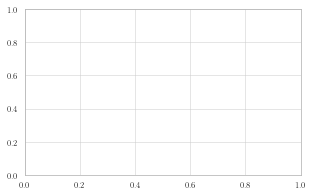

In [67]:
# dump modelnet dgcnn
std_delta_combinations = {
    0.05: [0.025, 0.05, 0.1],
    0.1: [0.05, 0.1, 0.2],
    0.2: [0.1, 0.2, 0.4],
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/dump'
sub_dir = 'modelnet40/dgcnn'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'dgcnn',
           certified_accuracy=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/final'
sub_dir = 'modelnet40/dgcnn'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'dgcnn',
           certified_accuracy=True)


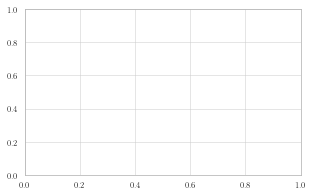

In [68]:
# dump modelnet pointnet
std_delta_combinations = {
    0.05: [0.025, 0.05, 0.1],
    0.1: [0.05, 0.1, 0.2],
    0.2: [0.1, 0.2, 0.4],
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/dump'
sub_dir = 'modelnet40/pointnet'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'pointnet',
           certified_accuracy=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/final'
sub_dir = 'modelnet40/pointnet'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'pointnet',
           certified_accuracy=True)


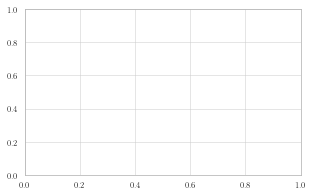

In [69]:
# dump modelnet pointnet attention
std_delta_combinations = {
    0.05: [0.025, 0.05, 0.1],
    0.1: [0.05, 0.1, 0.2],
    0.2: [0.1, 0.2, 0.4],
}

base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/dump'
sub_dir = 'modelnet40/pointnet_attention'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'pointnet_attention',
           certified_accuracy=True, format='png')



base_dir = '/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/final'
sub_dir = 'modelnet40/pointnet_attention'
dump_dir = os.path.join(base_dir, sub_dir)

dump_plots(results, dump_dir, std_delta_combinations, 'modelnet40', 'pointnet_attention',
           certified_accuracy=True)


10


/tmp/ipykernel_1520366/2299834661.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/final/modelnet40/dgcnn/0.1/0.1_main.svg', format='svg', tight={'pad': 0.1})


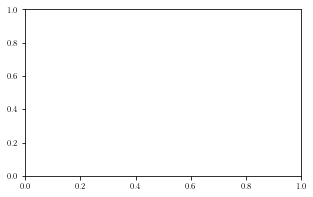

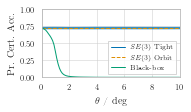

In [10]:
plot(results, 'modelnet40', 'dgcnn', 0.1, 0.1, certified_accuracy=True, width=0.49, legend_fontsize=7, xlim=10)
plt.tight_layout()
plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/rotation_3d/final/modelnet40/dgcnn/0.1/0.1_main.svg', format='svg', tight={'pad': 0.1})
